# Navigation

---

### 1. Start the Environment

We begin by importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
brain_name

'BananaBrain'

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
steps = 0
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    steps += 1
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
print("Total steps: {}".format(steps))

Score: 0.0
Total steps: 300


### 4. Training the Agent

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
Let's define the function for training as below,

In [6]:
from collections import deque
import torch
from dqn_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

def dqn(agent, file_saved_model, n_episodes = 2000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.995):
    """Deep Q-Learning."""
    # List containing scores from each episode
    scores = []
    # Last 100 scores
    scores_window = deque(maxlen = 100)
    # initial epsilon for epsilon-greedy policy
    eps = eps_start

    for i_episode in range(1, n_episodes + 1):
        # reset environment
        env_info = env.reset(train_mode=True)[brain_name]
        # get current state
        state = env_info.vector_observations[0]
        # initialize the score
        score = 0

        # start the episode
        while True:
            # choose action from epsilon-greedy pilicy based on current Q function estimation
            action = agent.act(state, eps)
            #print('Action choice: {}\tReturn type: {}'.format(action, type(action)))
            # send the action to the environment
            env_info = env.step(action)[brain_name]
            # get the next state
            next_state = env_info.vector_observations[0]
            # get the reward
            reward = env_info.rewards[0]
            # see if episode has finished
            done = env_info.local_done[0]

            # Learning
            agent.step(state, action, reward, next_state, done)

            # update the score
            score += reward
            # roll over the state to next time step
            state = next_state

            if done:
                break

        # Save most recent score
        scores.append(score)
        scores_window.append(score)
        # Decrease epsilon for epsilon-greedy policy
        eps = max(eps_end, eps_decay * eps)
        # Print learning process every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score of most recent 100 episodes: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
    torch.save(agent.qnetwork_local.state_dict(), file_saved_model)

    return scores

#### 4.1. Training with DQN

First, let's train the agent using original DQN (with fixed target Q netowrk).

Episode 100	Average Score of most recent 100 episodes: 0.74
Episode 200	Average Score of most recent 100 episodes: 2.58
Episode 300	Average Score of most recent 100 episodes: 3.74
Episode 400	Average Score of most recent 100 episodes: 6.59
Episode 500	Average Score of most recent 100 episodes: 8.87
Episode 600	Average Score of most recent 100 episodes: 8.60
Episode 700	Average Score of most recent 100 episodes: 10.77
Episode 800	Average Score of most recent 100 episodes: 11.67
Episode 900	Average Score of most recent 100 episodes: 10.40
Episode 1000	Average Score of most recent 100 episodes: 12.03
Episode 1100	Average Score of most recent 100 episodes: 11.45
Episode 1200	Average Score of most recent 100 episodes: 11.65
Episode 1300	Average Score of most recent 100 episodes: 11.73
Episode 1400	Average Score of most recent 100 episodes: 11.37
Episode 1500	Average Score of most recent 100 episodes: 13.50
Episode 1600	Average Score of most recent 100 episodes: 12.08
Episode 1700	Average Sc

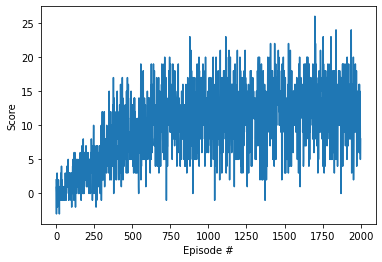

In [7]:
agent_dqn = Agent(state_size = 37, action_size = 4, seed = 1, hidden_layers = [128, 64])

scores = dqn(agent = agent_dqn, file_saved_model = 'trained_with_DQN.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('reward_plot_DQN.png', dpi=300, bbox_inches='tight')
plt.show()

#### 4.2. Training with double DQN

Now, let's train the agent using double DQN.

Episode 100	Average Score of most recent 100 episodes: 0.75
Episode 200	Average Score of most recent 100 episodes: 3.13
Episode 300	Average Score of most recent 100 episodes: 6.46
Episode 400	Average Score of most recent 100 episodes: 8.83
Episode 500	Average Score of most recent 100 episodes: 10.57
Episode 600	Average Score of most recent 100 episodes: 12.80
Episode 700	Average Score of most recent 100 episodes: 12.22
Episode 800	Average Score of most recent 100 episodes: 12.38
Episode 900	Average Score of most recent 100 episodes: 13.32
Episode 1000	Average Score of most recent 100 episodes: 12.74
Episode 1100	Average Score of most recent 100 episodes: 13.88
Episode 1200	Average Score of most recent 100 episodes: 13.94
Episode 1300	Average Score of most recent 100 episodes: 12.82
Episode 1400	Average Score of most recent 100 episodes: 13.83
Episode 1500	Average Score of most recent 100 episodes: 14.90
Episode 1600	Average Score of most recent 100 episodes: 14.95
Episode 1700	Average 

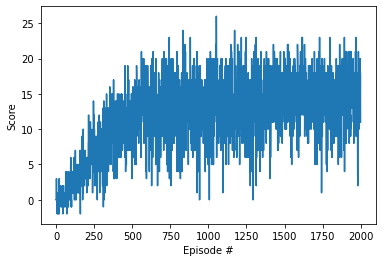

In [8]:
agent_double_dqn = Agent(state_size = 37, action_size = 4, seed = 1, hidden_layers = [128, 64], double_dqn = True)

scores = dqn(agent = agent_double_dqn, file_saved_model = 'trained_with_double_DQN.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('reward_plot_double_DQN.png', dpi=300, bbox_inches='tight')
plt.show()

#### 4.3. Training with DQN using prioritized experience replay

Lastly, let's try to train the agent uisng DQN with prioritized experience replay.

Episode 100	Average Score of most recent 100 episodes: 0.51
Episode 200	Average Score of most recent 100 episodes: 2.52
Episode 300	Average Score of most recent 100 episodes: 5.55
Episode 400	Average Score of most recent 100 episodes: 8.91
Episode 500	Average Score of most recent 100 episodes: 11.13
Episode 600	Average Score of most recent 100 episodes: 11.21
Episode 700	Average Score of most recent 100 episodes: 12.35
Episode 800	Average Score of most recent 100 episodes: 13.69
Episode 900	Average Score of most recent 100 episodes: 14.21
Episode 1000	Average Score of most recent 100 episodes: 13.04


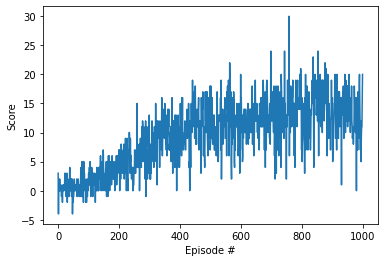

In [9]:
agent_per_dqn = Agent(state_size = 37, action_size = 4, seed = 1, hidden_layers = [128, 64], 
                      double_dqn = True, prioritized_replay = True)

scores = dqn(agent = agent_per_dqn, file_saved_model = 'trained_with_PER_DQN.pth', n_episodes = 1000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('reward_plot_PER_DQN.png', dpi=300, bbox_inches='tight')
plt.show()

When finished, you can close the environment.

In [10]:
env.close()